In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import LabelBinarizer
import re
import wordbatch
from wordbatch.models import FM_FTRL
from wordbatch.models import FTRL

[nltk_data] Downloading package stopwords to C:\Users\Ekta
[nltk_data]     Gandhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_csv("train.tsv", sep = '\t')
train = train.set_index(train.columns[0])
train.shape

(1482535, 7)

In [3]:
train.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
test = pd.read_csv("test.tsv", sep = '\t')
test = test.set_index(test.columns[0])
test.shape

(693359, 6)

In [5]:
test.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description
test_id,,,,,,
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [6]:
train = train[train.price > 0].reset_index(drop=True)
train.shape

(1481661, 7)

In [7]:
train['log_price'] = np.log1p(train['price'])

In [8]:
train['is_train'] = 1
test['is_train'] = 0

In [9]:
merge = pd.concat([train, test])
merge.shape

(2175020, 9)

In [10]:
merge.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,is_train
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895,1
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,1
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,1
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,1
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662,1


In [11]:
merge.tail()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,is_train
693354,Quartz crystal on Flint stone,1,Home/Home Décor/Home Décor Accents,NaN,NaN,0,Flint/Quartz cluster. Self mined ✨measures 3x2...,NaN,0
693355,It Cosmetics - Travel Bundle,1,Beauty/Makeup/Makeup Sets,IT Cosmetics,NaN,1,It Cosmetics travel bundle. Includes: Brow pow...,NaN,0
693356,Galaxy S8 hard shell case,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,NaN,1,New. Free shipping Basstop case,NaN,0
693357,Hi low floral kimono,2,Women/Swimwear/Cover-Ups,NaN,NaN,0,Floral kimono. Tropical print. Open front. Hi ...,NaN,0
693358,"FREESHIP 2 Floral Scrub Tops, medium.",2,Women/Tops & Blouses/T-Shirts,NaN,NaN,1,2 Floral scrub tops. Worn less than 5 times ea...,NaN,0


In [12]:
new = merge["category_name"].str.split("/", n = 2, expand = True)
merge["sub_category_1"] = new[0]
merge["sub_category_2"] = new[1]
merge["sub_category_3"] = new[2]
merge = merge.drop(['category_name'], axis =1)

In [13]:
merge.head()

,name,item_condition_id,brand_name,price,shipping,item_description,log_price,is_train,sub_category_1,sub_category_2,sub_category_3
0,MLB Cincinnati Reds T Shirt Size XL,3,NaN,10.0,1,No description yet,2.397895,1,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,1,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,1,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,1,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,NaN,44.0,0,Complete with certificate of authenticity,3.806662,1,Women,Jewelry,Necklaces


In [14]:
merge.isnull().sum()

name                      0
item_condition_id         0
brand_name           927861
price                693359
shipping                  0
item_description          6
log_price            693359
is_train                  0
sub_category_1         9372
sub_category_2         9372
sub_category_3         9372
dtype: int64

In [15]:
merge['item_description'].fillna(value='missing',inplace=True)
merge['sub_category_1'].fillna(value='missing',inplace=True)
merge['sub_category_2'].fillna(value='missing',inplace=True)
merge['sub_category_3'].fillna(value='missing',inplace=True)
merge['brand_name'].fillna(value='unbranded',inplace=True)

In [16]:
merge.isnull().sum()

name                      0
item_condition_id         0
brand_name                0
price                693359
shipping                  0
item_description          0
log_price            693359
is_train                  0
sub_category_1            0
sub_category_2            0
sub_category_3            0
dtype: int64

In [17]:
merge["sub_category_1"] = merge["sub_category_1"].str.lower()
merge["sub_category_1"] = merge["sub_category_1"].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','')
merge["sub_category_1"] = merge["sub_category_1"].str.replace('\d+','')

In [18]:
merge["sub_category_2"] = merge["sub_category_2"].str.lower()
merge["sub_category_2"] = merge["sub_category_2"].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','')
merge["sub_category_2"] = merge["sub_category_2"].str.replace('\d+','')

In [19]:
merge["sub_category_3"] = merge["sub_category_3"].str.lower()
merge["sub_category_3"] = merge["sub_category_3"].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','')
merge["sub_category_3"] = merge["sub_category_3"].str.replace('\d+','')

In [20]:
merge["brand_name"] = merge["brand_name"].str.lower()
merge["brand_name"] = merge["brand_name"].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','')
merge["brand_name"] = merge["brand_name"].str.replace('\d+','')

In [21]:
merge["name"] = merge["name"].str.lower()
merge["name"] = merge["name"].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','')
merge["name"] = merge["name"].str.replace('\d+','')

In [22]:
merge["item_description"] = merge["item_description"].str.lower()
merge["item_description"] = merge['item_description'].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','')
merge["item_description"] = merge['item_description'].str.replace('\d+','')

In [23]:
stop_words = stopwords.words('english')
merge["item_description"] = merge["item_description"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [24]:
df = pd.DataFrame(merge["item_description"])
df['tokenized_sents'] = df.apply(lambda row: nltk.word_tokenize(row['item_description']), axis=1)
merge["item_description"] = df['tokenized_sents']

In [25]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(item_description):
    words = item_description
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)
merge['item_description'] = merge['item_description'].apply(lemmatize_words)

Data Visualization

In [26]:
test = merge.loc[merge['is_train'] == 0]
train = merge.loc[merge['is_train'] == 1]

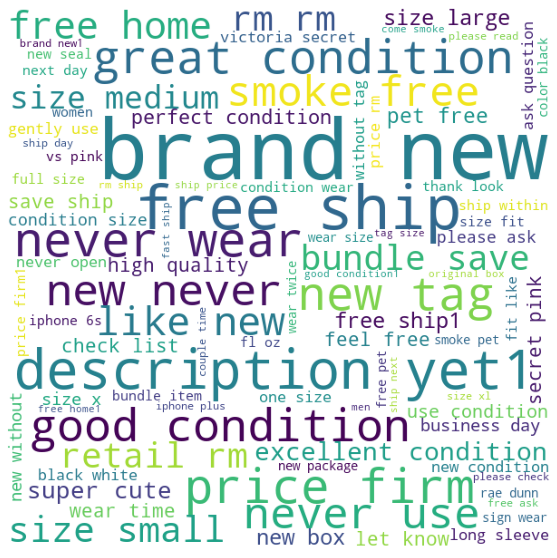

In [27]:
stopwords=set(stop_words)
word_cloud = WordCloud(width = 600, height = 600,background_color ='white', stopwords=stopwords,min_font_size = 10).generate("1 ".join(train['item_description']))
plt.figure(figsize = (15, 10))
plt.imshow(word_cloud)
plt.axis('off')                                             
plt.show()

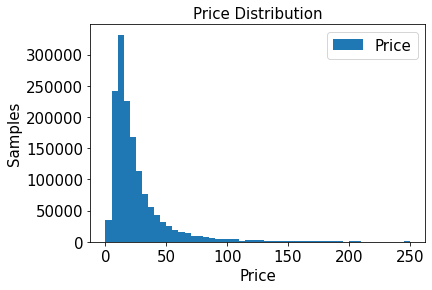

In [28]:
plt.hist(train['price'], bins=50, range=[0,250], label='Price')
plt.title('Price Distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

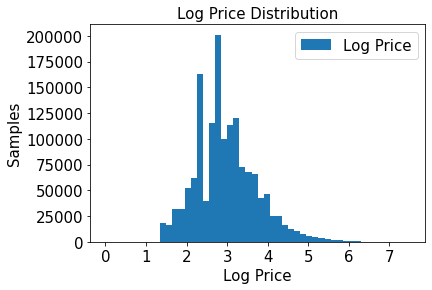

In [29]:
plt.hist(train['log_price'], bins=50, range=[0,7.5], label='Log Price')
plt.title('Log Price Distribution', fontsize=15)
plt.xlabel('Log Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

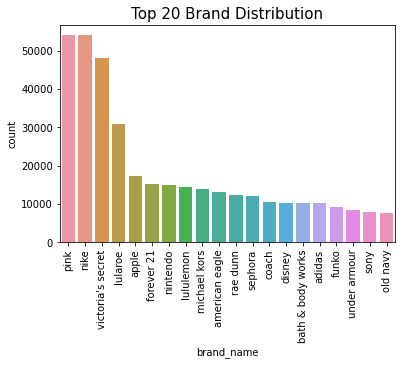

In [30]:
b20 = train['brand_name'].value_counts()[1:21].reset_index() 
ax = sns.barplot(x="brand_name", y="count", data=b20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Brand Distribution', fontsize=15)
plt.show()

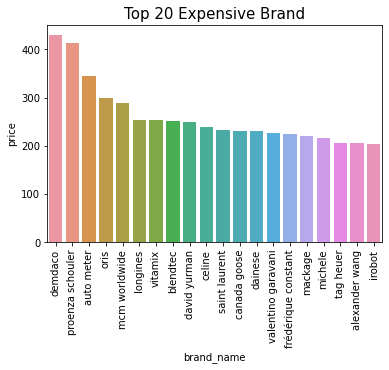

In [31]:
top20_brand = train.groupby('brand_name', axis=0)['price'].mean()
df_expPrice = pd.DataFrame(top20_brand.sort_values(ascending=False)[0:20].reset_index())
ax = sns.barplot(x="brand_name", y="price", data=df_expPrice)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Top 20 Expensive Brand', fontsize=15)
plt.show()

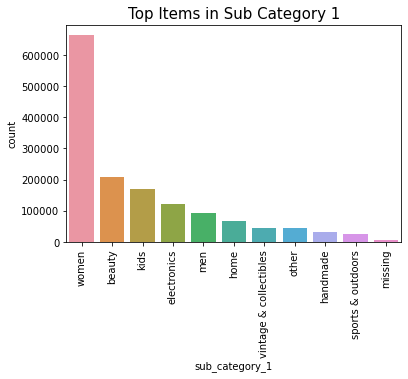

In [32]:
s1 = train['sub_category_1'].value_counts().reset_index()
ax = sns.barplot(x="sub_category_1", y="count", data=s1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top Items in Sub Category 1', fontsize=15)
plt.show()

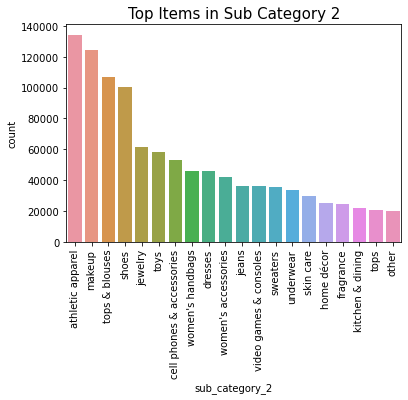

In [33]:
s1 = train['sub_category_2'].value_counts()[0:20].reset_index()
ax = sns.barplot(x="sub_category_2", y="count", data=s1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top Items in Sub Category 2', fontsize=15)
plt.show()

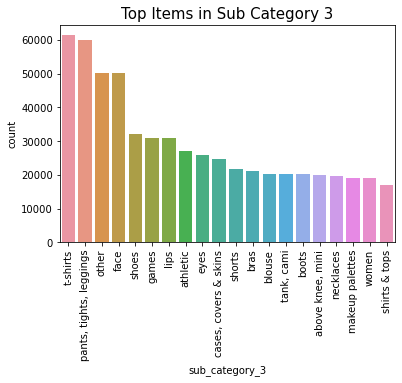

In [34]:
s1 = train['sub_category_3'].value_counts()[0:20].reset_index()
ax = sns.barplot(x="sub_category_3", y="count", data=s1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top Items in Sub Category 3', fontsize=15)
plt.show()

<AxesSubplot:xlabel='item_condition_id', ylabel='count'>

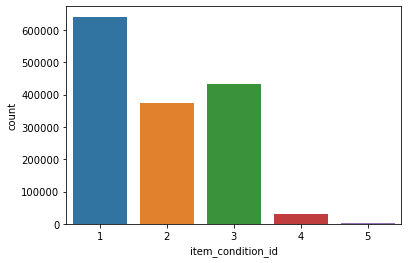

In [35]:
sns.countplot(x="item_condition_id", data=train)

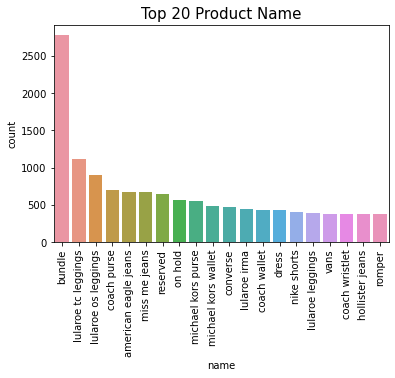

In [36]:
n20 = train['name'].value_counts()[0:20].reset_index()
ax = sns.barplot(x="name", y="count", data=n20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Product Name', fontsize=15)
plt.show()

<AxesSubplot:xlabel='shipping', ylabel='count'>

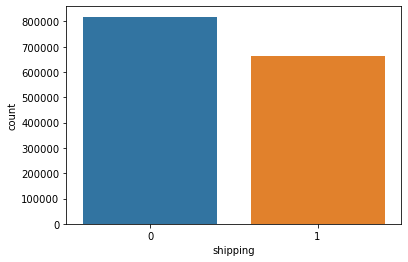

In [37]:
sns.countplot(x="shipping", data=train)

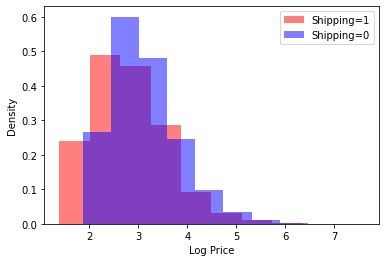

In [38]:
prices_ship1 = [p for p, s in zip(train['log_price'], train['shipping']) if s == 1]
prices_ship0 = [p for p, s in zip(train['log_price'], train['shipping']) if s == 0]
plt.hist(prices_ship1, color='r', alpha=0.5, density=True, label='Shipping=1')
plt.hist(prices_ship0, color='b', alpha=0.5, density=True, label='Shipping=0')
plt.xlabel('Log Price')
plt.ylabel('Density')
plt.legend()
plt.show()

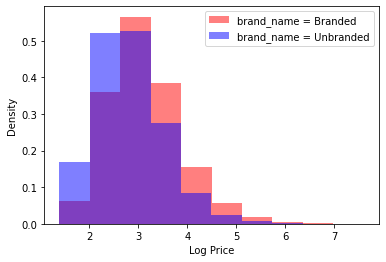

In [39]:
prices_branded = [p for p, s in zip(train['log_price'], train['brand_name']) if s != 'unbranded']
prices_unbranded = [p for p, s in zip(train['log_price'], train['brand_name']) if s == 'unbranded']
plt.hist(prices_branded, color='r', alpha=0.5, density=True, label='brand_name = Branded')
plt.hist(prices_unbranded, color='b', alpha=0.5, density=True, label='brand_name = Unbranded')
plt.xlabel('Log Price')
plt.ylabel('Density')
plt.legend()
plt.show()

Sentiment Analysis and Label Encoding

In [42]:
merge[['polarity', 'subjectivity']] = merge['item_description'].apply(lambda x: pd.Series(TextBlob(x).sentiment))
analyzer = SentimentIntensityAnalyzer()
sentiment_scores = merge['item_description'].apply(analyzer.polarity_scores)
merge['description'] = sentiment_scores.apply(lambda x: -1 if x['neg'] > x['pos'] else (1 if x['pos'] > x['neg'] else 0))
merge = merge.drop(['item_description'], axis=1)

In [43]:
label_encoder = preprocessing.LabelEncoder()
merge['brand_name'] = label_encoder.fit_transform(merge['brand_name'])
merge['sub_category_1'] = label_encoder.fit_transform(merge['sub_category_1'])
merge['sub_category_2'] = label_encoder.fit_transform(merge['sub_category_2'])
merge['sub_category_3'] = label_encoder.fit_transform(merge['sub_category_3'])
merge['name'] = label_encoder.fit_transform(merge['name'])

Model

In [44]:
test = merge.loc[merge['is_train'] == 0]
train = merge.loc[merge['is_train'] == 1]

In [45]:
test = test.drop(['is_train'], axis=1)
train = train.drop(['is_train'], axis=1)

In [46]:
train.head()

,name,item_condition_id,brand_name,price,shipping,log_price,sub_category_1,sub_category_2,sub_category_3,polarity,subjectivity,description
0,947456,3,4940,10.0,1,2.397895,5,102,775,0.000000,0.000000,0
1,1226767,3,3943,52.0,0,3.970292,1,30,215,0.600000,0.725000,1
2,190573,1,4646,10.0,1,2.397895,10,103,97,0.136250,0.422500,1
3,768605,1,4940,35.0,1,3.583519,3,55,410,0.232121,0.598182,1
4,63283,1,4940,44.0,0,3.806662,10,58,543,0.100000,0.400000,0


In [47]:
x = train.drop(['log_price', 'price'], axis=1)
y = train.loc[:, train.columns == 'log_price']

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [49]:
lr = LinearRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)

In [50]:
alpha = 1.0 
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(x_train, y_train)
ridge_pred = ridge_model.predict(x_test)

In [51]:
lasso = Lasso(alpha=0.1)
lasso.fit(x_train, y_train)
lasso_pred = lasso.predict(x_test)

In [52]:
gbr_regressor = GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42)
gbr_regressor.fit(x_train, y_train)
gbr_pred = gbr_regressor.predict(x_test)

In [53]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(x_train, y_train)
rfr_pred = rfr.predict(x_test)

In [54]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
sgd_model = SGDRegressor(max_iter=100000, tol=1e-3, random_state=42)
sgd_model.fit(x_train_scaled, y_train)
sgd_pred = sgd_model.predict(x_test_scaled)

In [55]:
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Gradient Boosting Regressor model', 'Random Forest Regressor','SGD Model']
y_preds_list = [lr_pred, ridge_pred, lasso_pred, gbr_pred, rfr_pred, sgd_pred]

In [56]:
def evaluate_regression_models(y_test, y_preds_list):
    num_models = len(y_preds_list)
    n = len(y_test)
    results = {}
    for i in range(num_models):
        model_name = models[i]
        y_pred = y_preds_list[i]
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - 2 - 1)
        results[model_name] = {'R-squared': '{:.2f}'.format(r2), 
                               'MSE': '{:.2f}'.format(mse), 
                               'RMSE': '{:.2f}'.format(rmse),
                               'MAE': '{:.2f}'.format(mae), 
                               'Adjusted R-squared': '{:.2f}'.format(adj_r2)}
    return results

In [57]:
results = pd.DataFrame(evaluate_regression_models(y_test, y_preds_list)).transpose()

In [58]:
sorted_results_1 = results.sort_values(by='R-squared', ascending=False)
sorted_results_1

,R-squared,MSE,RMSE,MAE,Adjusted R-squared
Random Forest Regressor,0.49,0.28,0.53,0.39,0.49
Gradient Boosting Regressor model,0.31,0.38,0.62,0.48,0.31
Linear Regression,0.08,0.51,0.72,0.56,0.08
Ridge Regression,0.08,0.51,0.72,0.56,0.08
SGD Model,0.08,0.51,0.72,0.56,0.08
Lasso Regression,0.03,0.54,0.74,0.57,0.03
